In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil.parser import parse
from utils import mean_2d_diff_size

Read the logs of our implementation

In [2]:
LOGS_PATH = "../logs/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'batch_100' in f and 'epochs_1000' in f and 'json' in f]

In [3]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data = pd.concat(logs, axis=0, ignore_index=True)
for field in ['end_time', 'start-time', 'start-compute-time', 'end-compute-time']:
    data[field] = data[field].apply(parse)
data['compute-time'] = (data['end-compute-time'] - data['start-compute-time'])/np.timedelta64(1, 's')

Read the logs of the Hogwild implementation

In [4]:
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'hogwild_log' in f and 'json' in f]

In [5]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data_hog = pd.concat(logs, axis=0, ignore_index=True)
data_hog.head()

,accuracy_-1_test,accuracy_-1_train,accuracy_-1_val,accuracy_1_test,accuracy_1_train,accuracy_1_val,accuracy_test,accuracy_train,accuracy_val,end_time,losses_train,losses_val,n_workers,running_mode,running_time,start_time,sync_epochs
0,0.961193,0.970842,0.966311,0.881881,0.910311,0.891522,0.923577,0.942693,0.930856,2019-04-13 12:38:29.405069,"[{'worker_idx': 1, 'loss_train': 1.0, 'time': ...","[{'time': '2019-04-13 12:33:40.721752', 'loss_...",2,synchronous,321.804225,2019-04-13 12:33:07.600843,918
1,0.824644,0.848373,0.839935,0.947501,0.950767,0.945218,0.882913,0.896088,0.888937,2019-04-14 12:28:29.577482,"[{'worker_idx': 2, 'loss_train': 1.0, 'time': ...","[{'time': '2019-04-14 12:26:19.845459', 'loss_...",4,synchronous,163.895204,2019-04-14 12:25:45.682278,171
2,0.926778,0.939258,0.938385,0.912782,0.926703,0.914645,0.920140,0.933429,0.926966,2019-04-14 14:12:18.224593,"[{'worker_idx': 3, 'loss_train': 1.00314402580...","[{'time': '2019-04-14 14:10:33.659405', 'loss_...",4,asynchronous,131.502992,2019-04-14 14:10:06.721601,0
3,0.969556,0.973213,0.962036,0.834091,0.850360,0.846654,0.905307,0.915959,0.908384,2019-04-13 12:24:38.868508,"[{'worker_idx': 0, 'loss_train': 1.0, 'time': ...","[{'time': '2019-04-13 12:23:39.313079', 'loss_...",1,synchronous,92.999979,2019-04-13 12:23:05.868529,313
4,0.950259,0.961798,0.948304,0.898902,0.919979,0.912639,0.925901,0.942309,0.931720,2019-04-14 14:20:43.114263,"[{'worker_idx': 1, 'loss_train': 0.99390423297...","[{'time': '2019-04-14 14:18:14.840434', 'loss_...",3,asynchronous,174.222815,2019-04-14 14:17:48.891448,0


Plot the running time vs number of workers for each implementation: synchronous, asynchronous and spark synchronous.

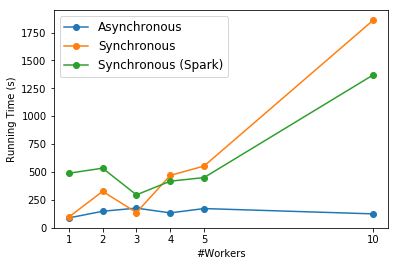

In [6]:
### Hogwild
by_sync = data_hog.groupby('running_mode')
for rmode in by_sync:
    mode = rmode[0]
    times = []
    workers = []
    for w_count in rmode[1].groupby('n_workers'):
        work = int(w_count[0])
        workers.append(work)
        time = np.mean(w_count[1]['running_time'].values)
        times.append(time)
    zipped_sorted = sorted(zip(workers, times), key=lambda x: x[0])
    (workers, times) = zip(*zipped_sorted)
    plt.plot(workers, times, 'o-', label=mode.capitalize())

### Spark
by_workers = data.groupby('num_workers')
times = []
workers = []
for i in by_workers:
    compute_time = i[1]['compute-time']
    workers.append(i[0])
    times.append(np.mean(compute_time))

plt.plot(workers, times, 'o-', label='Synchronous (Spark)')
### plot
plt.rc('font', size=12)
plt.xlabel('#Workers')
plt.ylabel('Running Time (s)')
plt.xticks(workers)
plt.legend()
plt.savefig('workers_running_time.png', bbox_inches='tight')
plt.show()

Plot the test accuracy vs number of workers for each implementation: synchronous, asynchronous and spark synchronous.

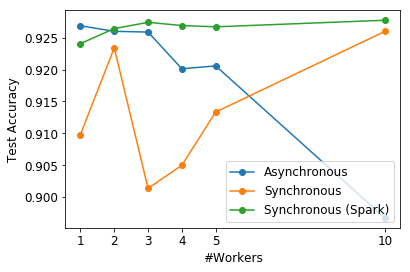

In [7]:
### Hogwild
by_sync = data_hog.groupby('running_mode')
for rmode in by_sync:
    mode = rmode[0]
    accs = []
    workers = []
    for w_count in rmode[1].groupby('n_workers'):
        work = int(w_count[0])
        workers.append(work)
        acc = np.mean(w_count[1]['accuracy_test'].values)
        accs.append(acc)
    zipped_sorted = sorted(zip(workers, accs), key=lambda x: x[0])
    (workers, accs) = zip(*zipped_sorted)
    plt.plot(workers, accs, 'o-', label=mode.capitalize())

    
### Spark
by_workers = data.groupby('num_workers')
test_accs = []
workers = []
for i in by_workers:
    acc = np.array(i[1]['test_accuracy'].values)
    workers.append(i[0])
    test_accs.append(np.mean(acc))
plt.plot(workers, test_accs, 'o-', label="Synchronous (Spark)")

### General plot info
plt.rc('font', size=12)
plt.xlabel('#Workers')
plt.ylabel('Test Accuracy')
plt.xticks(workers)
plt.legend()
plt.savefig('workers_test_accuracy.png', bbox_inches='tight')
plt.show()

Plot the convergence of the validation loss for each implementation: synchronous, asynchronous and spark synchronous.

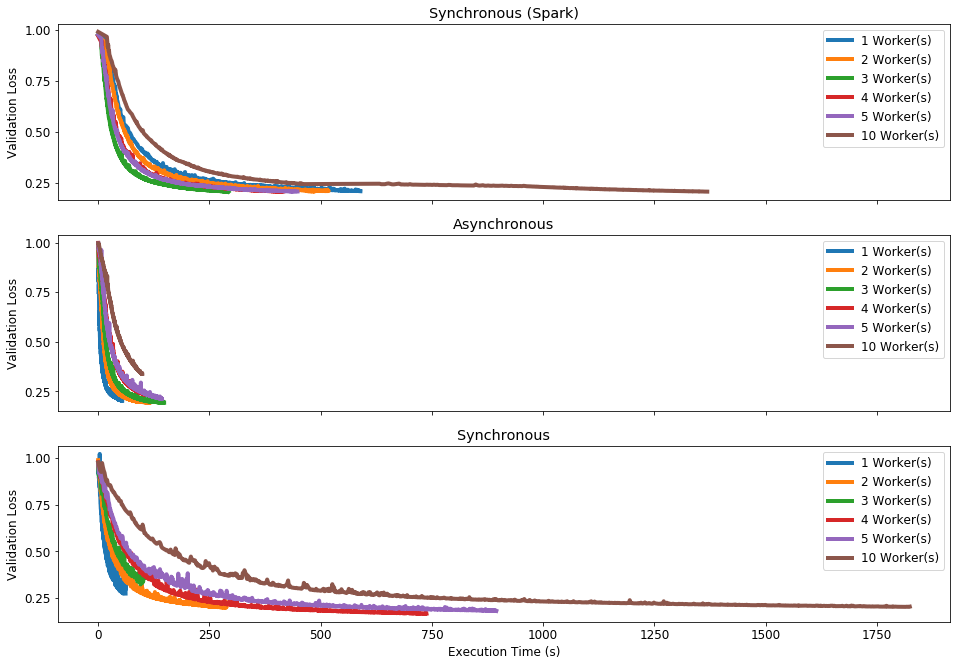

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,11), sharex=True)

## Spark
by_workers = data.groupby('num_workers')
for i in by_workers:
    epoch_history = i[1]['epochs-stats'].values
    worker_ttstamps = []
    worker_losses = []
    for stat in epoch_history:
        start_time = parse(stat[0]['epoch_start'])
        # list of timestamps for this run
        time_stamps = [(parse(epoch['epoch_start']) - start_time).total_seconds() for epoch in stat]
        worker_ttstamps.append(time_stamps)
        
        # list of losses for this run
        losses = [epoch['val_loss'] for epoch in stat]
        worker_losses.append(losses)
    
    # average
    mean_worker_ttstamps = mean_2d_diff_size(worker_ttstamps)
    mean_losses = mean_2d_diff_size(worker_losses)
    ax1.set_title('Synchronous (Spark)')
    ax1.plot(mean_worker_ttstamps, mean_losses, 
             label="{} Worker(s)".format(i[0]), 
             linewidth=4)
    ax1.legend()
## Hogwild
by_mode = data_hog.groupby('running_mode')
for m in by_mode:
    mode = m[0]
    by_workers = m[1].groupby('n_workers')
    ax = ax2 if mode == 'asynchronous' else ax3
    for w in sorted(by_workers,key=lambda x: int(x[0])):
        num_workers = w[0]
        worker_all_timestamps = []
        worker_all_losses = []
        for run in w[1]['losses_val']:
            initial_time = parse(run[0]['time'])
            this_run_timestamps = [(parse(epoch['time']) - initial_time)\
                                   .total_seconds()
                                   for epoch in run]
            worker_all_timestamps.append(this_run_timestamps)
            this_run_losses = [epoch['loss_val'] for epoch in run]
            worker_all_losses.append(this_run_losses)
        worker_mean_timestamps = mean_2d_diff_size(worker_all_timestamps)
        worker_mean_losses = mean_2d_diff_size(worker_all_losses)
        
        ax.plot(worker_mean_timestamps, worker_mean_losses, 
                label = "{} Worker(s)".format(num_workers),
                linewidth=4)
        ax.set_title(mode.capitalize())
        ax.legend()
for ax in ax1, ax2, ax3:  
    ax.set_ylabel('Validation Loss')

plt.xlabel('Execution Time (s)')
plt.rc('font', size=18)
plt.savefig('conv_val_loss.png', bbox_inches='tight')
plt.show()

Plot for different batch sizes

In [9]:
LOGS_PATH = "../logs/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'workers_10' in f and 'epochs_1000' in f and 'json' in f]

In [10]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data = pd.concat(logs, axis=0, ignore_index=True)
for field in ['end_time', 'start-time', 'start-compute-time', 'end-compute-time']:
    data[field] = data[field].apply(parse)
data['compute-time'] = (data['end-compute-time'] - data['start-compute-time'])/np.timedelta64(1, 's')

In [11]:
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'hogwild' in f and '10w' in f and 'json' in f]

In [12]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data_hog = pd.concat(logs, axis=0, ignore_index=True)

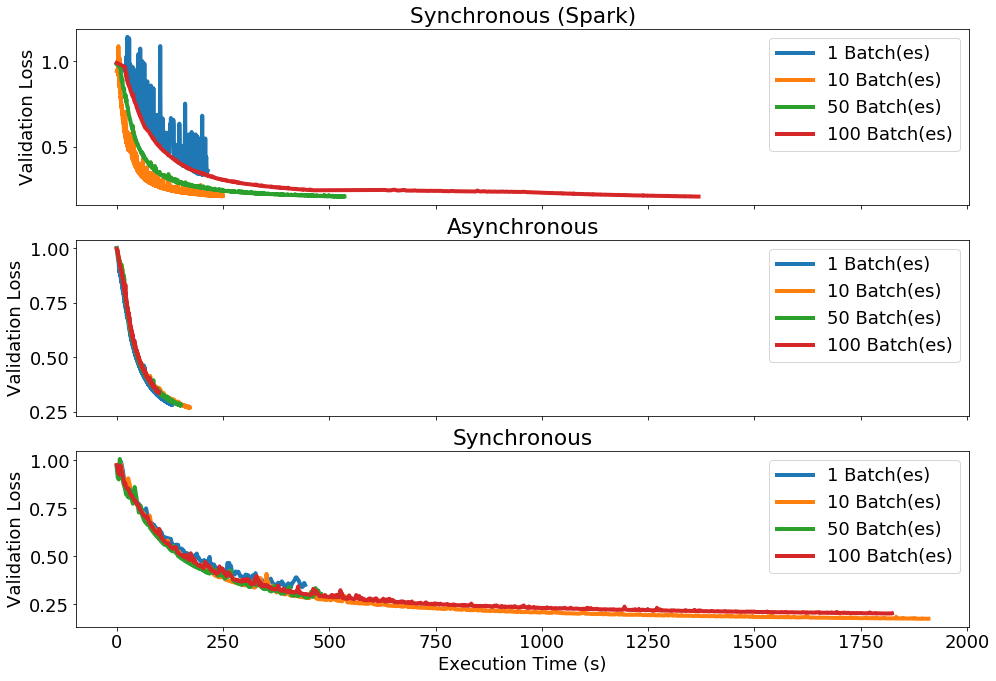

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,11), sharex=True)

## Spark
by_batches = data.groupby('batch')
for i in by_batches:
    epoch_history = i[1]['epochs-stats'].values
    worker_ttstamps = []
    worker_losses = []
    for stat in epoch_history:
        start_time = parse(stat[0]['epoch_start'])
        # list of timestamps for this run
        time_stamps = [(parse(epoch['epoch_start']) - start_time).total_seconds() for epoch in stat]
        worker_ttstamps.append(time_stamps)
        
        # list of losses for this run
        losses = [epoch['val_loss'] for epoch in stat]
        worker_losses.append(losses)
    
    # average
    mean_worker_ttstamps = mean_2d_diff_size(worker_ttstamps)
    mean_losses = mean_2d_diff_size(worker_losses)
    ax1.set_title('Synchronous (Spark)')
    ax1.plot(mean_worker_ttstamps, mean_losses, 
             label="{} Batch(es)".format(i[0]), 
             linewidth=4)
    ax1.legend()
## Hogwild
by_mode = data_hog.groupby('running_mode')
for m in by_mode:
    mode = m[0]
    by_batches = m[1].groupby('batch')
    ax = ax2 if mode == 'asynchronous' else ax3
    for b in sorted(by_batches,key=lambda x: int(x[0])):
        batches = b[0]
        worker_all_timestamps = []
        worker_all_losses = []
        for run in b[1]['losses_val']:
            initial_time = parse(run[0]['time'])
            this_run_timestamps = [(parse(epoch['time']) - initial_time)\
                                   .total_seconds()
                                   for epoch in run]
            worker_all_timestamps.append(this_run_timestamps)
            this_run_losses = [epoch['loss_val'] for epoch in run]
            worker_all_losses.append(this_run_losses)
        worker_mean_timestamps = mean_2d_diff_size(worker_all_timestamps)
        worker_mean_losses = mean_2d_diff_size(worker_all_losses)
        
        ax.plot(worker_mean_timestamps, worker_mean_losses, 
                label = "{} Batch(es)".format(batches),
                linewidth=4)
        ax.set_title(mode.capitalize())
        ax.legend()
for ax in ax1, ax2, ax3:  
    ax.set_ylabel('Validation Loss')

plt.xlabel('Execution Time (s)')
plt.rc('font', size=18)
plt.savefig('batch_conv_val_loss.png', bbox_inches='tight')
plt.show()